In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras import layers

## Load Data
Define a function that imports all the data from the provided csv files

In [2]:
csv_paths = glob.glob("data/*.csv")
csv_filenames = [os.path.splitext(os.path.basename(x))[0] for x in csv_paths]

def load_data_from_csv():
    """Loads the csv files to pandas DataFrames and saves
    them in a dictionary with their filenames as keys"""
    data = dict()
    for csv_filename, csv_path in zip(csv_filenames, csv_paths):
        data[csv_filename] = pd.read_csv(csv_path)
    return data

# Load the data to a Dictionary
data = load_data_from_csv()

Inspect the data, the schema is shown below:

<img src="docs/schema.png">

First replace the chinese brands with their english names

In [3]:
# Join chinese brand names to their english equivalents
phone_brand_device_model = pd.merge(data["phone_brand_device_model"],
                                    data["chinese_to_english_brand"],
                                    left_on="phone_brand", right_on="chinese_brand", how="left")

# Fill nans for brands already in english
phone_brand_device_model["brand"] =\
    phone_brand_device_model["brand"].where(phone_brand_device_model["brand"].str.isalpha(),
                                                    phone_brand_device_model["phone_brand"].str.lower())

# We will just work with device brand and model for the time being
device_data = phone_brand_device_model[["device_id", "brand", "device_model"]]
device_data

,device_id,brand,device_model
0,-8890648629457979026,xiaomi,红米
1,1277779817574759137,xiaomi,MI 2
2,5137427614288105724,samsung,Galaxy S4
3,3669464369358936369,SUGAR,时尚手机
4,-5019277647504317457,samsung,Galaxy Note 2
...,...,...,...
187240,7979541072208733273,xiaomi,MI 4
187241,-187404680852357705,xiaomi,红米2
187242,-2718274279595622821,xiaomi,MI 3
187243,3098391762071677791,vivo,X1


We can encode the brand and device model data

In [4]:
encoder = LabelEncoder().fit(device_data["brand"] + " " + device_data["device_model"])

device_data["encoded_brand_model"] = encoder.transform(device_data["brand"] + " " + device_data["device_model"])

device_data.sort_values(by=["encoded_brand_model"])

<ipython-input-4-09855a868b17>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  device_data["encoded_brand_model"] = encoder.transform(device_data["brand"] + " " + device_data["device_model"])


,device_id,brand,device_model,encoded_brand_model
123784,5014627883795280526,AUX,V965T,0
71804,-231815432814429273,AUX,V965T,0
67660,-4567000646686758042,AUX,V965T,0
75906,8567026160899753334,AUX,V965T,0
34250,5489607796787403797,AUX,V965T,0
...,...,...,...,...
144356,-2217351983095398459,首云,P1,1664
163118,-1527969048433963834,首云,P1,1664
98617,-6315989391792706778,鲜米,S970,1665
26395,7388463854850737017,鲜米,s800,1666


In [5]:
print(f'There are {len(device_data["device_id"].unique())} unique devices in the device data')
# Get rid of duplicates in the device data
device_data_cln = device_data.drop_duplicates("device_id")
print(len(device_data_cln))

There are 186716 unique devices in the device data
186716


We'll proceed to join the device brand data to the train data

In [6]:
combined_data = data["gender_age_train"]
print(len(combined_data))
combined_data = pd.merge(combined_data, device_data_cln, on="device_id", how="left")
combined_data

74645


,device_id,gender,age,group,brand,device_model,encoded_brand_model
0,-8076087639492063270,M,35,M32-38,xiaomi,MI 2,1565
1,-2897161552818060146,M,35,M32-38,xiaomi,MI 2,1565
2,-8260683887967679142,M,35,M32-38,xiaomi,MI 2,1565
3,-4938849341048082022,M,30,M29-31,xiaomi,红米note,1587
4,245133531816851882,M,30,M29-31,xiaomi,MI 3,1569
...,...,...,...,...,...,...,...
74640,4682031842235089751,M,30,M29-31,xiaomi,MI 3,1569
74641,-9178703742877135986,M,30,M29-31,xiaomi,MI 3,1569
74642,180946546684162312,M,20,M22-,xiaomi,红米note,1587
74643,1390702386071991851,M,37,M32-38,huawei,Ascend P8,873


# Approach 1

Since most of the devices do not have event data we will first attempt to infer gender and age using only the device brand and model data

In [7]:
FEATURE_COLUMNS = ["encoded_brand_model"]
LABELS = ["gender"]

# Prepare the labels
y = combined_data[LABELS]
#y = pd.get_dummies(y, prefix='', prefix_sep='')
le = LabelEncoder()
le.fit(y.to_numpy().ravel())
y_enc = le.transform(y)
y_enc

C:\Users\LONAA32\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


array([1, 1, 1, ..., 1, 1, 1])

In [8]:
# Prepare the features
X = combined_data[FEATURE_COLUMNS]
X = pd.get_dummies(X, columns=['encoded_brand_model'], prefix='', prefix_sep='')
X_enc = X.to_numpy()
X_enc

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

#### Split dataset into train, validation and test sets.

In [9]:
# Split into train and test set
X_train, X_test, y_train, y_test = train_test_split(X_enc, y_enc, test_size=0.2, random_state=1)
# Split into train set further into train and validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)
print(len(X_train), 'train examples')
print(len(X_val), 'validation examples')
print(len(X_test), 'test examples')

44787 train examples
14929 validation examples
14929 test examples


In [10]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(1, activation="sigmoid", input_shape=(1486,)),  # input shape required
])

In [11]:
predictions = model(X_train)
predictions[:5]

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[0.48567203],
       [0.50921685],
       [0.5031442 ],
       [0.49872348],
       [0.49589306]], dtype=float32)>

In [12]:
tf.nn.softmax(predictions[:5])

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[1.],
       [1.],
       [1.],
       [1.],
       [1.]], dtype=float32)>

In [22]:
model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

In [23]:
history = model.fit(X_train, y_train, epochs=10, verbose=1, validation_data=(X_val, y_val))

Epoch 1/10
1400/1400 [==============================] - 1s 966us/step - loss: 0.6488 - accuracy: 0.6409 - val_loss: 0.6631 - val_accuracy: 0.6227
Epoch 2/10
1400/1400 [==============================] - 1s 938us/step - loss: 0.6494 - accuracy: 0.6400 - val_loss: 0.6642 - val_accuracy: 0.6252
Epoch 3/10
1400/1400 [==============================] - 1s 917us/step - loss: 0.6501 - accuracy: 0.6404 - val_loss: 0.6654 - val_accuracy: 0.6238
Epoch 4/10
1400/1400 [==============================] - 1s 1ms/step - loss: 0.6508 - accuracy: 0.6386 - val_loss: 0.6665 - val_accuracy: 0.6240
Epoch 5/10
1400/1400 [==============================] - 1s 1ms/step - loss: 0.6515 - accuracy: 0.6392 - val_loss: 0.6675 - val_accuracy: 0.6229
Epoch 6/10
1400/1400 [==============================] - 1s 931us/step - loss: 0.6521 - accuracy: 0.6384 - val_loss: 0.6685 - val_accuracy: 0.6208
Epoch 7/10
1400/1400 [==============================] - 1s 930us/step - loss: 0.6528 - accuracy: 0.6376 - val_loss: 0.6697 - val

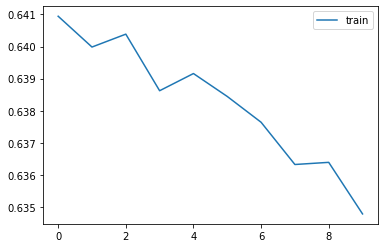

In [24]:
# plot history
plt.plot(history.history["accuracy"], label='train')
plt.legend()
plt.show()

In [29]:
print(y_test[:20])

[1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 1 1 1]


In [26]:
predictions = model.predict(X_test)

In [28]:
print(np.where(predictions[0:20] > 0.5, 1, 0))

[[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]]
